In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from numpy.linalg import svd


# Part 1: Epipolar Geometry (30 Points)


## Overview

In this problem, you will implement an algorithm for automatically estimating homography with RANSAC. In the file matches.mat, we provide the detected Harris corners row-column positions in variables r1 c1 for the first image; variables r2 c2 for the second image; and the corresponding matched pairs in the variable matches.

<!-- <img src="https://drive.google.com/uc?id=1Tr723u5OXmwkd4RDmu9z886ITJU9j1cL&export=download" width="800"/> -->

<img src="https://www.cs.umd.edu/class/spring2023/cmsc426-0201/hw_images/epipolar_geometry.jpg" width="800"/>


The outline of the normalized 8-point algorithm:

<img src="https://www.cs.umd.edu/class/spring2023/cmsc426-0201/hw_images/8pointalgo.jpg" width="700"/>



## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
!unzip "/content/Part1_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part1_data/matches.mat')
r1 = data['r1']
r2 = data['r2']
c1 = data['c1']
c2 = data['c2']
matches = data['matches']

Downloading...
From: https://drive.google.com/uc?id=1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
To: /content/Part1_data.zip
100% 157k/157k [00:00<00:00, 68.8MB/s]
Archive:  /content/Part1_data.zip
   creating: /content/Part1_data/
  inflating: /content/Part1_data/chapel00.png  
  inflating: /content/Part1_data/chapel01.png  
  inflating: /content/Part1_data/matches.mat  


In [ ]:
# Load Keypoints
x1 = c1[matches[:,0]-1]
y1 = r1[matches[:,0]-1]
x2 = c2[matches[:,1]-1]
y2 = r2[matches[:,1]-1]

## Helper Functions

In [ ]:
from scipy.ndimage import gaussian_filter as gf
from google.colab.patches import cv2_imshow

def show_image(img, scale=1.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray()
    plt.axis('off')
    plt.show()


### Code (15 pt)

In [ ]:
def ransacF(x1, y1, x2, y2, threshold=1.5, iterations=1000):
  # Find normalization matrix
  # Transform point set 1 and 2
  # RANSAC based 8-point algorithm
  T1 = normalize(x1, y1)
  T2 = normalize(x2, y2)

  pt1 = np.column_stack((x1, y1, np.ones(len(x1))))
  pt2 = np.column_stack((x2, y2, np.ones(len(x2))))

  pt1_norm = (np.dot(T1, pt1.T)).T
  pt2_norm = (np.dot(T2, pt2.T)).T

  max_inliers = 0
  best_F = None

  # RANSAC based 8-point algorithm
  for k in range(iterations):
      # Randomly sample 8 points
      rp = np.random.permutation(len(x1))
      i = rp[:8]
      F = computeF(pt1_norm[i, 0], pt1_norm[i, 1], pt2_norm[i, 0], pt2_norm[i, 1])

      # De-normalize F
      F = np.dot(T1.T, np.dot(F, T2))

      # Get inliers using the getInliers function
      inliers = getInliers(pt1, pt2, F, threshold)

      if len(inliers) > max_inliers:
          max_inliers = len(inliers)
          best_F = F

  return best_F, max_inliers


def getInliers(pt1, pt2, F, thresh):
  # Function: implement the criteria checking inliers.

  num_points = pt1.shape[0]
  err1 = np.zeros(num_points)
  err2 = np.zeros(num_points)

  # calculate error in pts1
  for n in range(num_points):
      epipolar_line = np.dot(F, pt2[n, :].reshape(3,1))
      epipolar_line /= np.sqrt(epipolar_line[0]**2 + epipolar_line[1]**2)
      err1[n] = abs(np.dot(pt1[n, :], epipolar_line))

  # calculate error in pts2
  for n in range(num_points):
      epipolar_line = np.dot(F, pt1[n, :])
      epipolar_line /= np.sqrt(epipolar_line[0]**2 + epipolar_line[1]**2)
      err2[n] = abs(np.dot(pt2[n, :], epipolar_line))

  inliers = np.where((err1 <= thresh) & (err2 <= thresh))[0]

  return inliers


def normalize(x, y):
  # Function: find the transformation to make it zero mean and the variance as sqrt(2)
  T = np.dot(np.array([[1/np.std(x), 0, 0],
                       [0, 1/np.std(y), 0],
                       [0, 0, 1]]),
            np.array([[1, 0, -np.mean(x)],
                      [0, 1, -np.mean(y)],
                      [0, 0, 1]]))
  return T


def computeF(x1, y1, x2, y2):
  #  Function: compute fundamental matrix from corresponding points

  # Construst A matrix as shown in lecture to take the form Ax=0
  A = np.column_stack((x1 * x2, x1 * y2, x1,
                        y1 * x2, y1 * y2, y1,
                        x2, y2, np.ones(len(x1))))
  # Solution for Ax=0 is found by SVD
  _, _, V = svd(A)
  F = V.T[:, -1].reshape(3, 3)
  U, S, V = svd(F)
  S[-1] = 0
  F = np.dot(U, np.dot(np.diag(S), V))
  return F


def plot_epipolar_lines(img1, img2, F, pt1, pt2, sample_indices):
    # Plot the images with corresponding epipolar lines
    plt.figure(figsize=(15, 15))

    # Plot image 1
    plt.subplot(1, 2, 1)
    plt.imshow(img1,cmap='gray')
    plt.scatter(pt1[sample_indices, 0], pt1[sample_indices, 1], c='r', marker='o')
    for i in sample_indices:
        line = np.dot(F.T, pt1[i, :])
        x = np.array([0, img1.shape[1] - 1])
        y = (-line[2] - line[0] * x) / line[1]
        plt.plot(x, y, linewidth=1.5,color='green')

    plt.title('Image 1')
    plt.axis('off')

    # Plot image 2
    plt.subplot(1, 2, 2)
    plt.imshow(img2,cmap='gray')
    plt.scatter(pt2[sample_indices, 0], pt2[sample_indices, 1], c='r', marker='o')
    for i in sample_indices:
        line = np.dot(F, pt2[i, :])
        x = np.array([0, img2.shape[1] - 1])
        y = (-line[2] - line[0] * x) / line[1]
        plt.plot(x, y, linewidth=1.5,color='green')

    plt.title('Image 2')
    plt.axis('off')

    plt.show()




The estimated Fundamental Matrix after normalization: 
 [[ 7.21630736e-06  1.92088631e-05 -4.70903048e-02]
 [-4.99359132e-05  2.06709966e-05  1.77337286e-01]
 [ 4.27386875e-02 -1.75687171e-01  1.00000000e+00]]


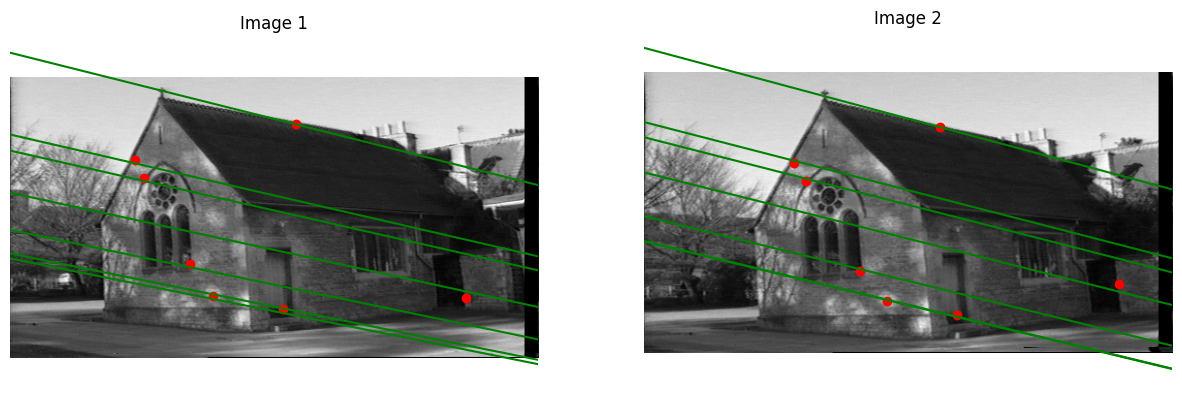

In [ ]:
# estimate the fundamental matrix F
# normalize F so the last entry is 1
# NOTE: this normalization is different than what the normalize function above does
# this is just a simple normalization that scales the matrix so the last entry is 1

# Load the images
img1 = plt.imread('/content/Part1_data/chapel00.png')
img2 = plt.imread('/content/Part1_data/chapel01.png')

# Estimate the fundamental matrix F
F, max_inliers = ransacF(x1, y1, x2, y2)

# Normalize F so the last entry is 1
F /= F[-1, -1]
print("The estimated Fundamental Matrix after normalization: \n", F)

# plot the images with the corresponding epipolar lines

# Construct homogenous point arrays
pt1 = np.column_stack((x1, y1, np.ones(len(x1))))
pt2 = np.column_stack((x2, y2, np.ones(len(x2))))

# Randomly select 7 sets of matching points
sample_indices = random.sample(range(len(x1)), 7)

# Plot the corresponding epipolar lines and the points on each image
plot_epipolar_lines(img1, img2, F, pt1, pt2, sample_indices)


### Write-up (15 pt)
*   Describe what test you used for deciding inlier vs. outlier. (**Answer Below**)
*   Print the estimated fundamental matrix F after normalizing to unit length (**Find Above**)
*   Randomly select 7 sets of matching points. Plot the corresponding epipolar lines and the points on each image. Show the two images (with plotted points and lines) next to each other. (**Find Above**)

<!-- *   Plot the outlier keypoints with green dots on top of the first image -->
<!-- *   Randomly select 7 sets of matching points. Plot the corresponding epipolar lines ('g’) and the points (with 'r+’) on each image. Show the two images (with plotted points and lines) next to each other. -->



*   Describe what test you used for deciding inlier vs. outlier:
* **Answer**:

In the getInliers function, it used the distance as the error metric to deccide whether a point pair is an inlier or an outlier. the distance is a measure of the geometric distance between corresponding points and their corresponding epipolar lines.

The function calculates the error for each point in both sets of points (pt1 and pt2) by computing the absolute value of the dot product between the point and the corresponding epipolar line. The epipolar line is normalized by dividing it by the square root of the sum of the squares of its first two components (x and y).

Then, the function checks if the errors for both points in a pair are less than or equal to the given threshold (in the above example, a threshold of 1.5 is tested). If both errors are below the threshold, the point pair is considered an inlier, and its indices are stored in the inliers array.





### Hint

*   You can use cv2.cornerHarris in opencv.
*   For visualization, you can use cv2.line, cv2.circle or any other helper functions in opencv or matplotlib.


# Part 2: Image stitching (30 points)

<img src="https://www.cs.umd.edu/class/spring2023/cmsc426-0201/hw_images/image_stitching.png" width="800"/>

## Overview

In this problem, you will implement an algorithm for automatically estimating the fundamental matrix F using RANSAC and the normalized 8-point algorithm.

Image Stitching Algorithm Overview
1. Detect keypoints
2. Match keypoints
3. Estimate homography with matched keypoints (using RANSAC)
4. Combine images

**Note:**  Do not use existing image stitching code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
!unzip "/content/hill.zip" -d "/content/hill"

!gdown 1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
!unzip "/content/tv.zip" -d "/content/tv"


Downloading...
From: https://drive.google.com/uc?id=1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
To: /content/hill.zip
100% 205k/205k [00:00<00:00, 97.6MB/s]
Archive:  /content/hill.zip
replace /content/hill/1.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Downloading...
From: https://drive.google.com/uc?id=1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
To: /content/tv.zip
100% 130k/130k [00:00<00:00, 84.8MB/s]
Archive:  /content/tv.zip
replace /content/tv/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Helper Functions

In [ ]:
import cv2

def drawMatches(image1, kp1, image2, kp2, idx_pairs):
    keypt1 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp1.tolist()]
    keypt2 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp2.tolist()]
    matches = [cv2.DMatch(pair[0], pair[1], 0) for pair in idx_pairs.tolist()]
    return cv2.drawMatches(image1, keypt1, image2, keypt2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

def plot_matches(images, feature_coord, matches, img_idx):
    matched_img = drawMatches(images[img_idx], feature_coord[img_idx], images[img_idx-1],
                              feature_coord[img_idx-1], matches[img_idx-1])

    cv2.imshow('Matches Found', matched_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def est_homography(src, dest):
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    return V.T[:, 8].reshape(3, 3)

def apply_homography(H, src):
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]

### Code (15 pt)

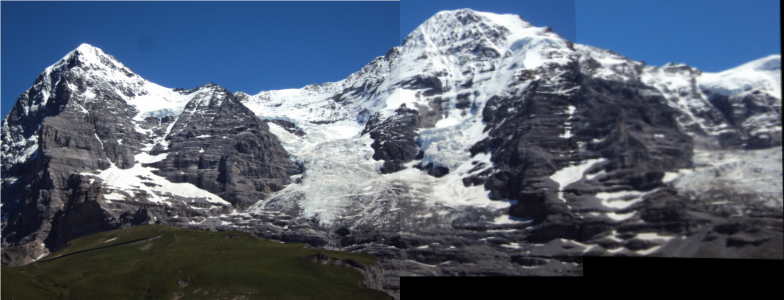

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


def image_stitching(image1, image2, image3):
    # First, stitch image1 and image2 together
    stitched_12,_ = stitch_two_images(image1, image2)

    # Next, stitch the result with image3
    stitched_result, best_H = stitch_two_images(stitched_12, image3)

    return stitched_result, best_H

def stitch_two_images(image1, image2):
    img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    #1. Detect keypoints using SIFT
    sift = cv2.xfeatures2d.SIFT_create()

    keypoints1, descriptors_1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors_2 = sift.detectAndCompute(img2, None)

    #2. Match keypoints
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors_1, descriptors_2)
    good_matches = sorted(matches, key=lambda x: x.distance)

    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

    max_inliers = 0
    best_H = None
    threshold = 1.5
    iterations = 1000

    #3. Estimate homography with matched keypoints (using RANSAC)
    for k in range(iterations):
        idx = np.random.choice(len(src_pts), 8, replace=False)
        src_sample = src_pts[idx]
        dst_sample = dst_pts[idx]

        H = est_homography(src_sample, dst_sample)
        transformed_pts = apply_homography(H, src_pts)

        error = np.sqrt(np.sum((transformed_pts - dst_pts) ** 2, axis=1))
        inliers = np.sum(error < threshold)

        if inliers > max_inliers:
            max_inliers = inliers
            best_H = H

    #4. Combine images
    h1, w1 = image1.shape[:2]
    h2, w2 = image2.shape[:2]
    canvas_size = (w1 + w2, max(h1, h2))
    result = cv2.warpPerspective(image1, best_H, canvas_size)
    result[0:h2, 0:w2] = image2

    return result, best_H


def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    elif not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    elif not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop right
    elif not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

# Hill imgs
image1 = cv2.imread('/content/hill/1.JPG')
image2 = cv2.imread('/content/hill/2.JPG')
image3 = cv2.imread('/content/hill/3.JPG')

# TV imgs
#image1 = cv2.imread('/content/tv/1.jpg')
#image2 = cv2.imread('/content/tv/2.jpg')
#image3 = cv2.imread('/content/tv/3.jpg')

# Stitch the three images together
stitched_images, best_H = image_stitching(image3, image2, image1)
trimmed_result = trim(stitched_images)

# Display the result
cv2_imshow(trimmed_result)

### Write-up (15 pt)
*  Describe how to remove incorrect matches with RANSAC
*  Display the best homography H after RANSAC
*  Display the blended images

1. Describe how to remove incorrect matches with RANSAC:
**Answer:**
The code uses the RANSAC algorithm to remove incorrect matches while estimating the homography between two images. RANSAC iteratively selects random keypoint pairs, computes the homography, and counts inliers (correct matches) based on a threshold by calculating the Euclidean distance (error) between the transformed points and the destination keypoints (dst_pts). This error measures how well the homography maps the source keypoints to the destination keypoints. The homography with the highest number of inliers is considered the best, effectively filtering out outliers and ensuring accurate image stitching


In [ ]:
#2 Display the best homography H after RANSAC
print("The best Homography H after RANSAC: \n", best_H)

The best Homography H after RANSAC: 
 [[-5.91509823e-03 -3.44741257e-04 -9.97539581e-01]
 [ 6.58543603e-04 -6.58286963e-03  6.92058355e-02]
 [ 2.37579860e-06 -2.56564309e-07 -6.81627954e-03]]


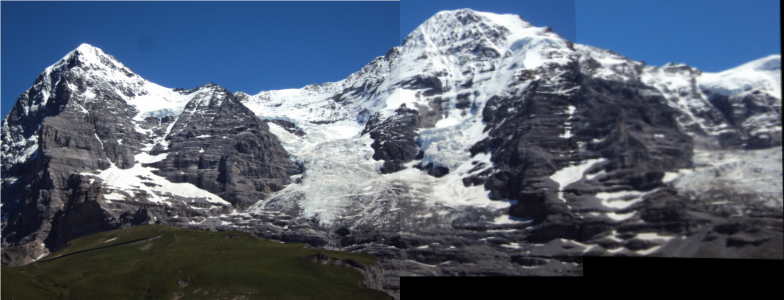

In [ ]:
#3 Display the blended images
cv2_imshow(trimmed_result)

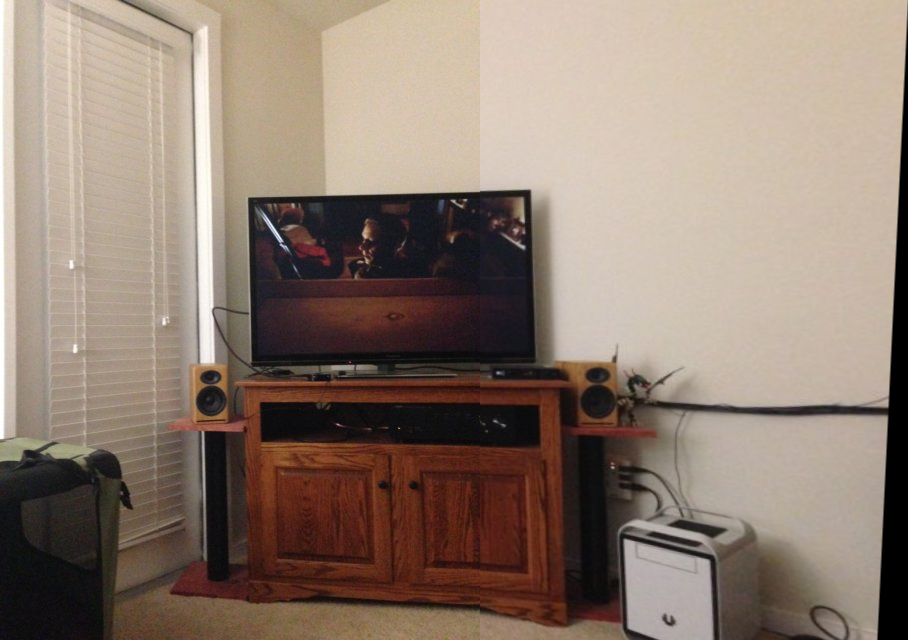

In [ ]:
# TV imgs
image1 = cv2.imread('/content/tv/1.jpg')
image2 = cv2.imread('/content/tv/2.jpg')
image3 = cv2.imread('/content/tv/3.jpg')

stitched_images,_ = stitch_two_images(image2, image1)
trimmed_result = trim(stitched_images)

# Display the result
cv2_imshow(trimmed_result)

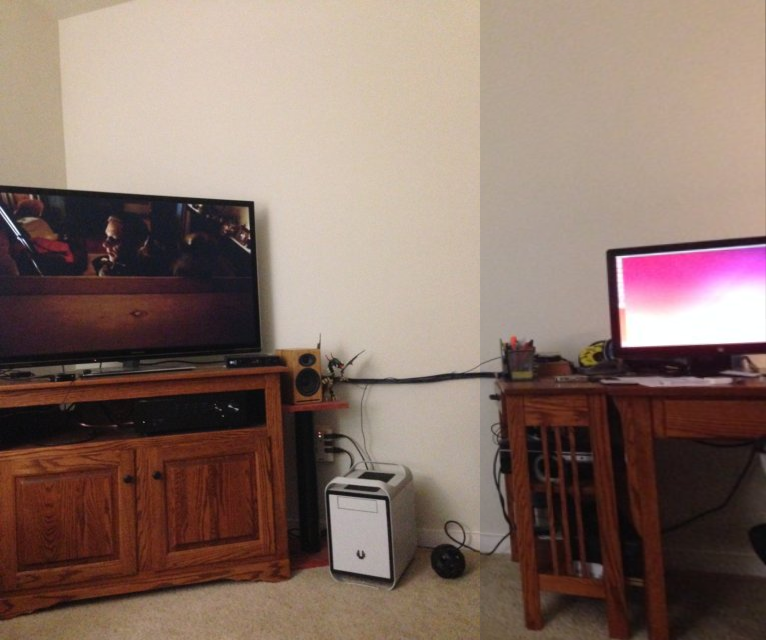

In [ ]:
stitched_images,_ = stitch_two_images(image3, image2)
trimmed_result = trim(stitched_images)

# Display the result
cv2_imshow(trimmed_result)

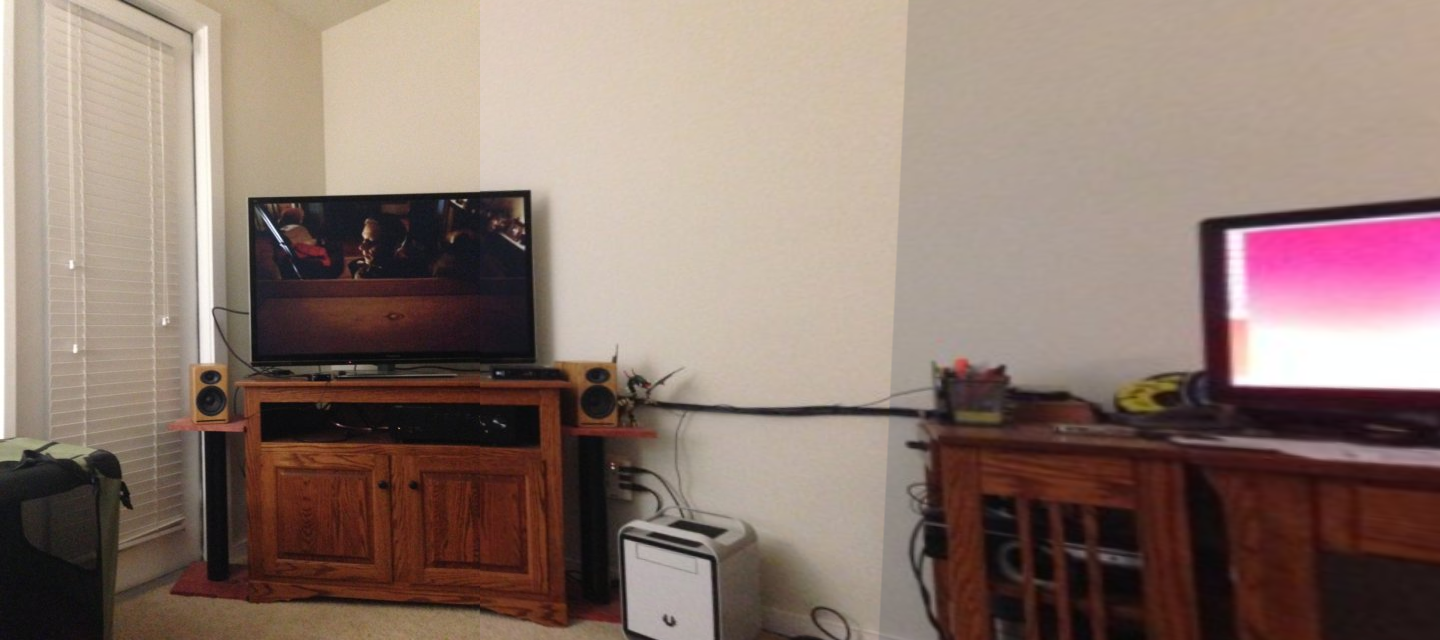

In [ ]:
# TV imgs
image1 = cv2.imread('/content/tv/1.jpg')
image2 = cv2.imread('/content/tv/2.jpg')
image3 = cv2.imread('/content/tv/3.jpg')

# Stitch the three images together
stitched_images, best_H = image_stitching(image3, image2, image1)
trimmed_result = trim(stitched_images)

# Display the result
cv2_imshow(trimmed_result)